# Setup env

In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  
import keras
import keras.backend as K
from keras.callbacks import CSVLogger


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-czvmw_g5
  Running command git clone -q https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-czvmw_g5
  Created wheel for gif-your-nifti: filename=gif_your_nifti-0.2.2-py3-none-any.whl size=6634 sha256=34cc40a5eba33c7a5f408587c10eb4fd91742167afe83d0cfe8a0d46ba96c4e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-hvo3feo5/wheels/4a/8c/d1/b228c3b67231f7459e8f70d73f4dadaf65cd90692d41f43e88
Successfully built gif-your-nifti
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

Text(0.5, 1.0, 'Mask')

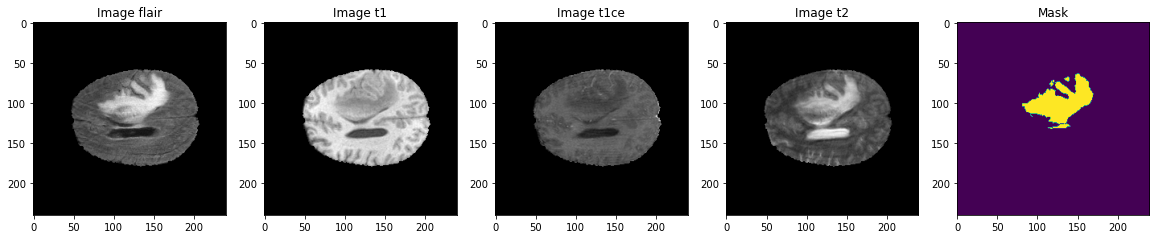

In [3]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


**Show whole nifti data -> print each slice from 3d data**

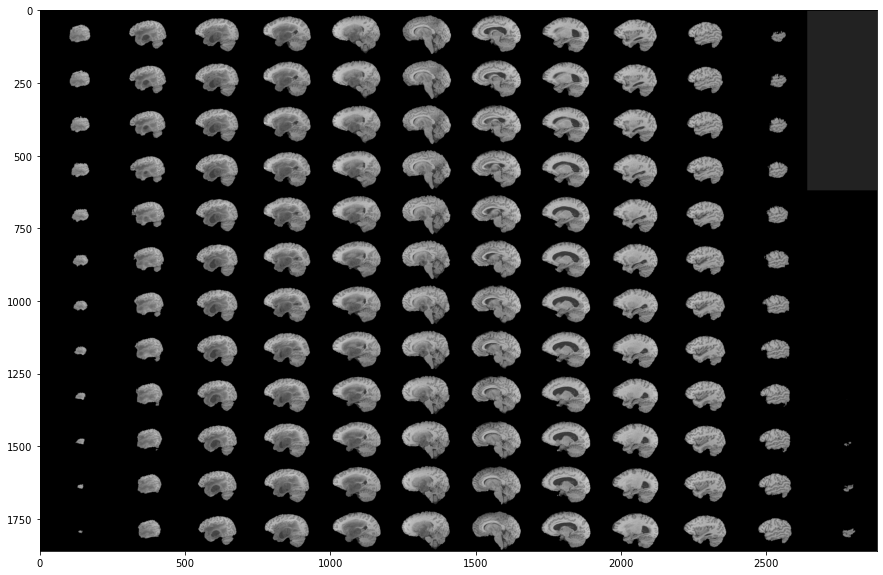

In [4]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

**Show segment of tumor for each above slice**

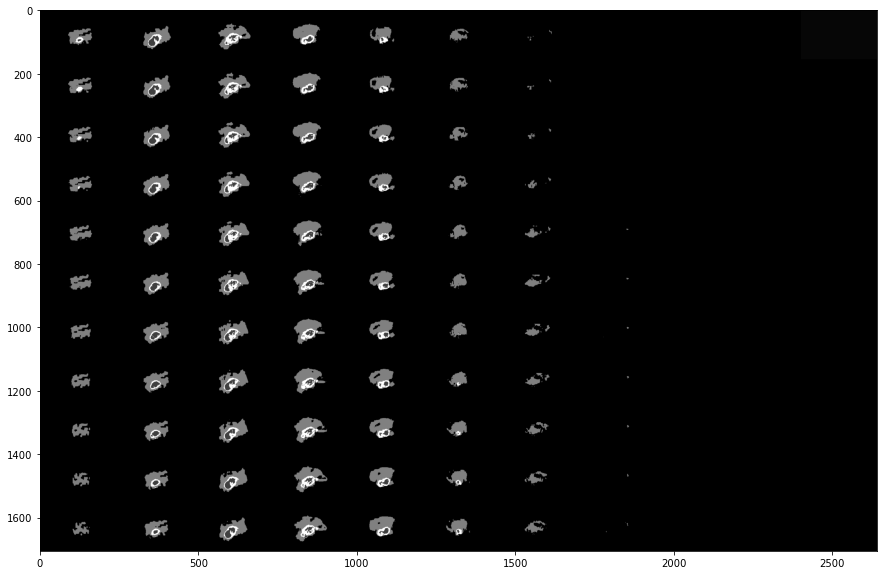

In [5]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [6]:
shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')
gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

**Gif representation of slices in 3D volume**
<img src="https://media1.tenor.com/images/15427ffc1399afc3334f12fd27549a95/tenor.gif?itemid=20554734">

**Show segments of tumor using different effects**

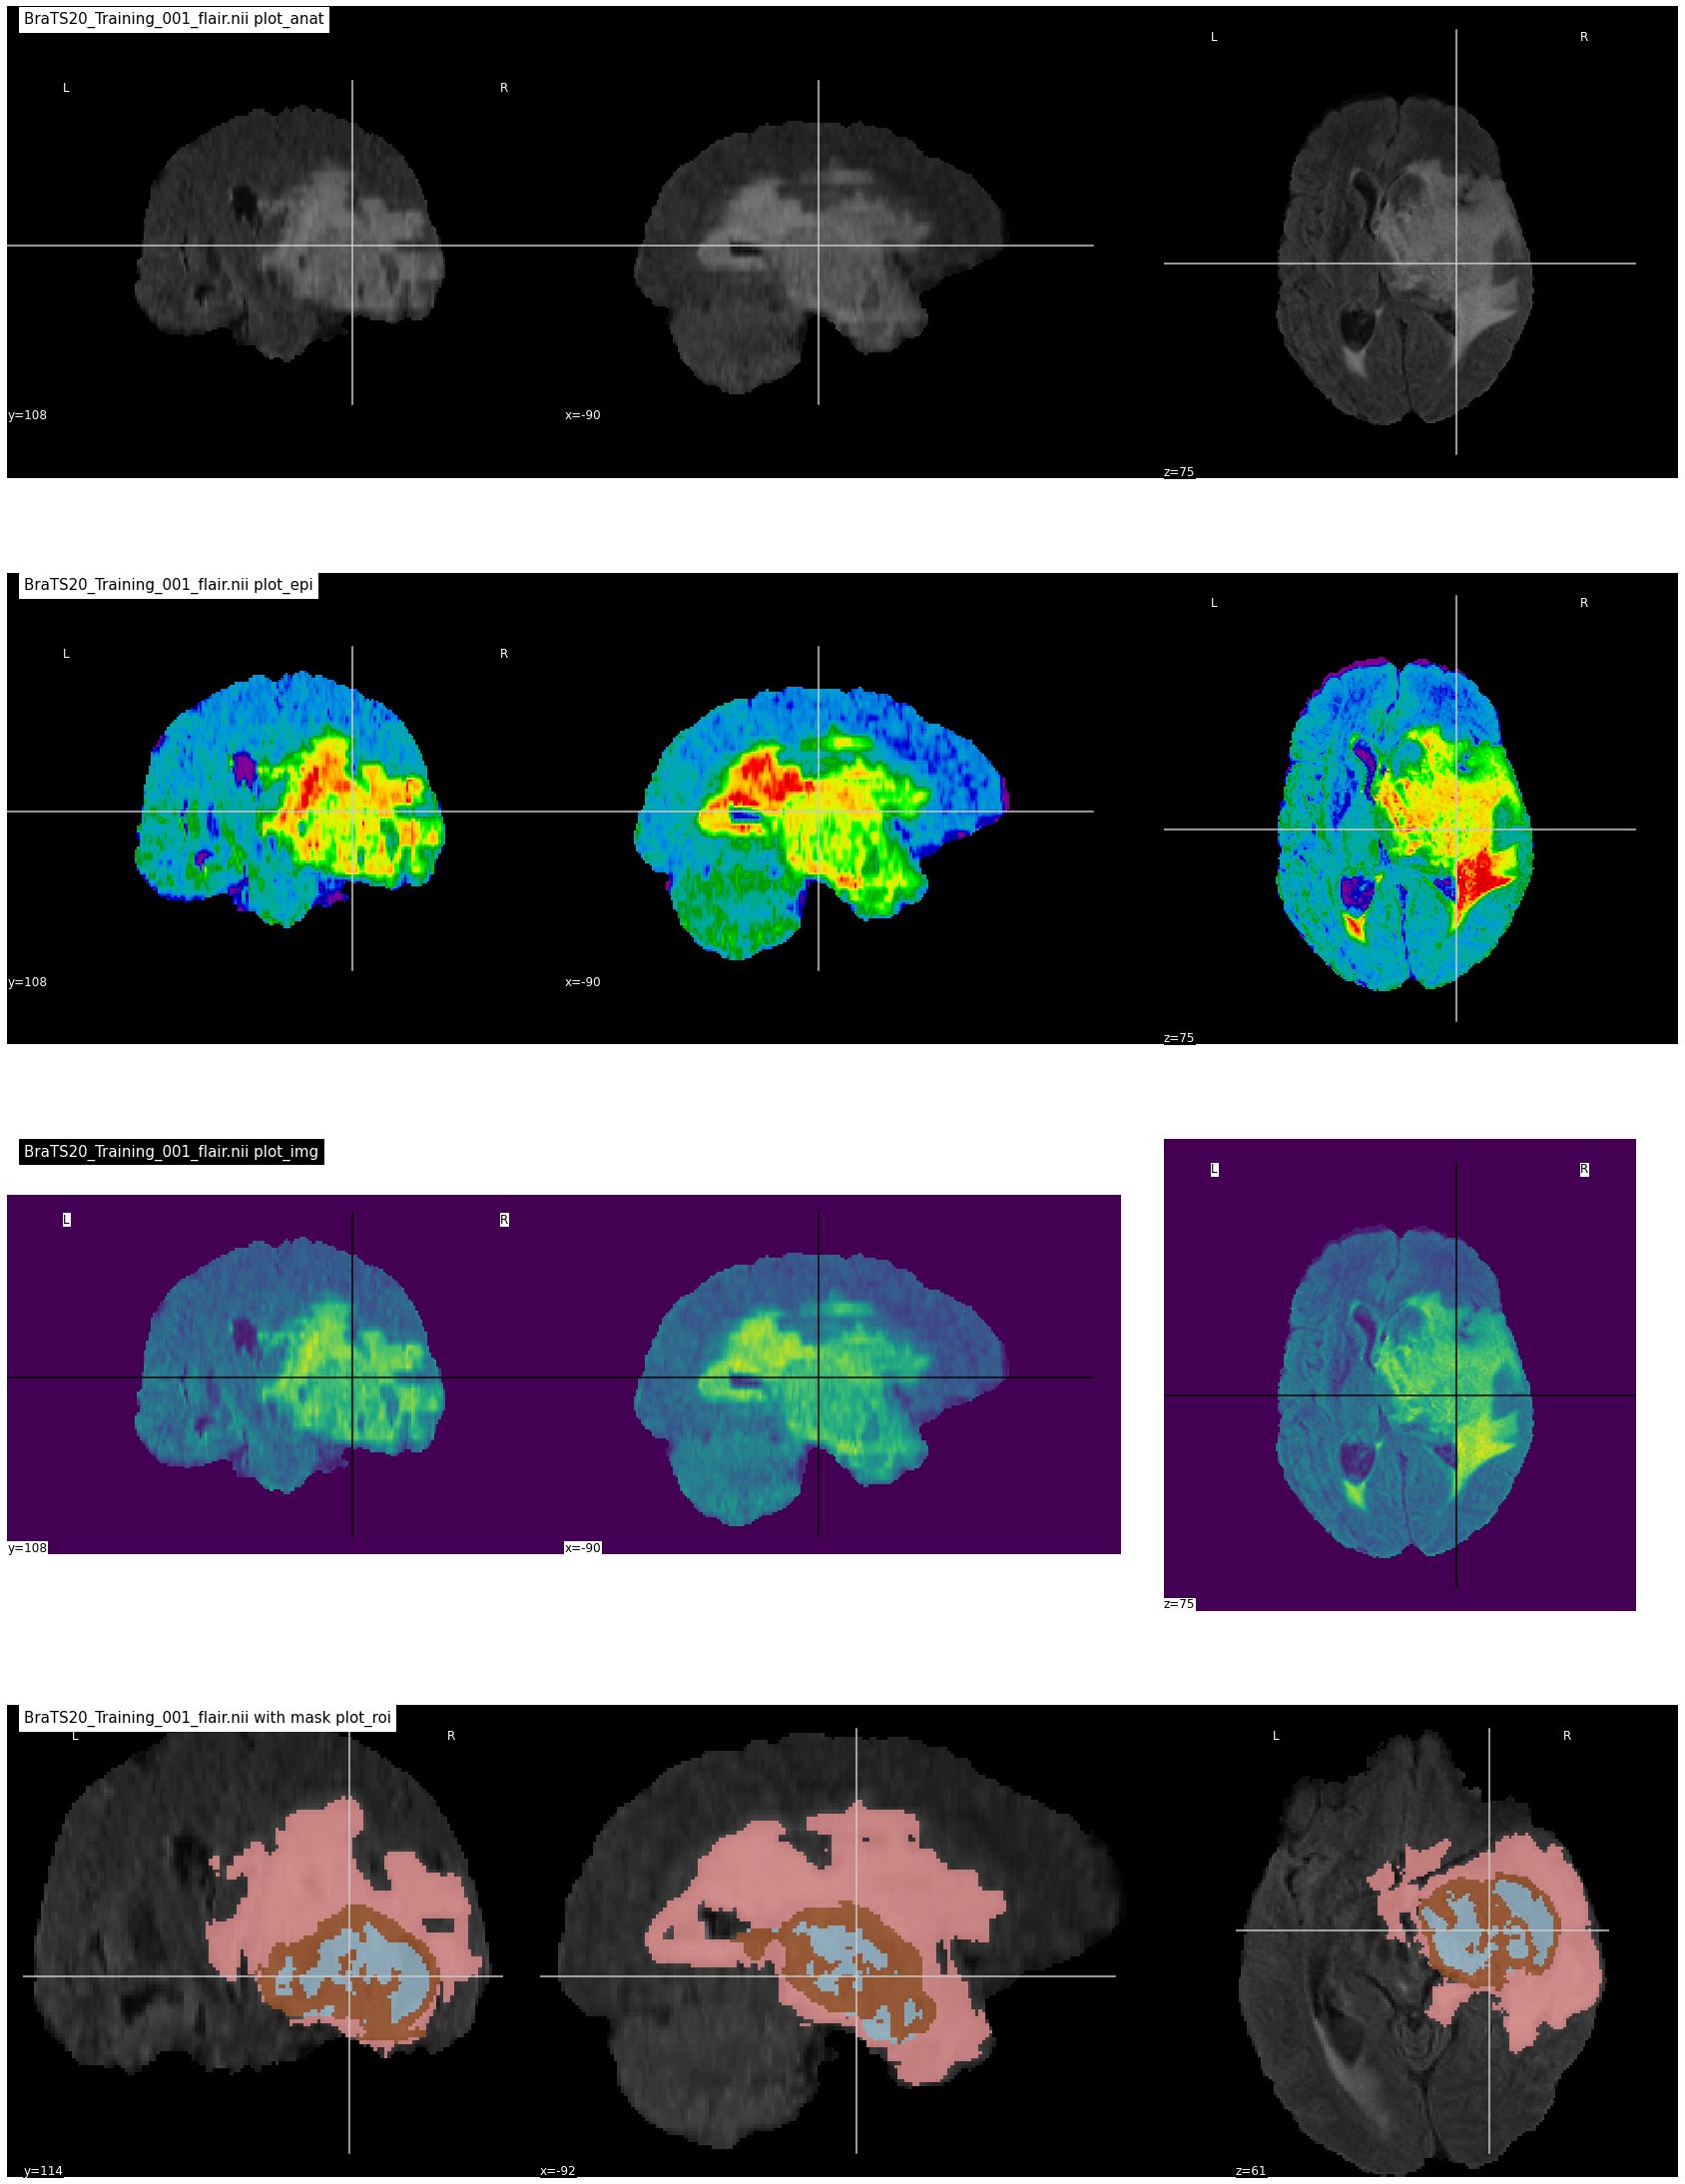

In [7]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [8]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [9]:
IMG_SIZE=128

In [10]:
# source https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

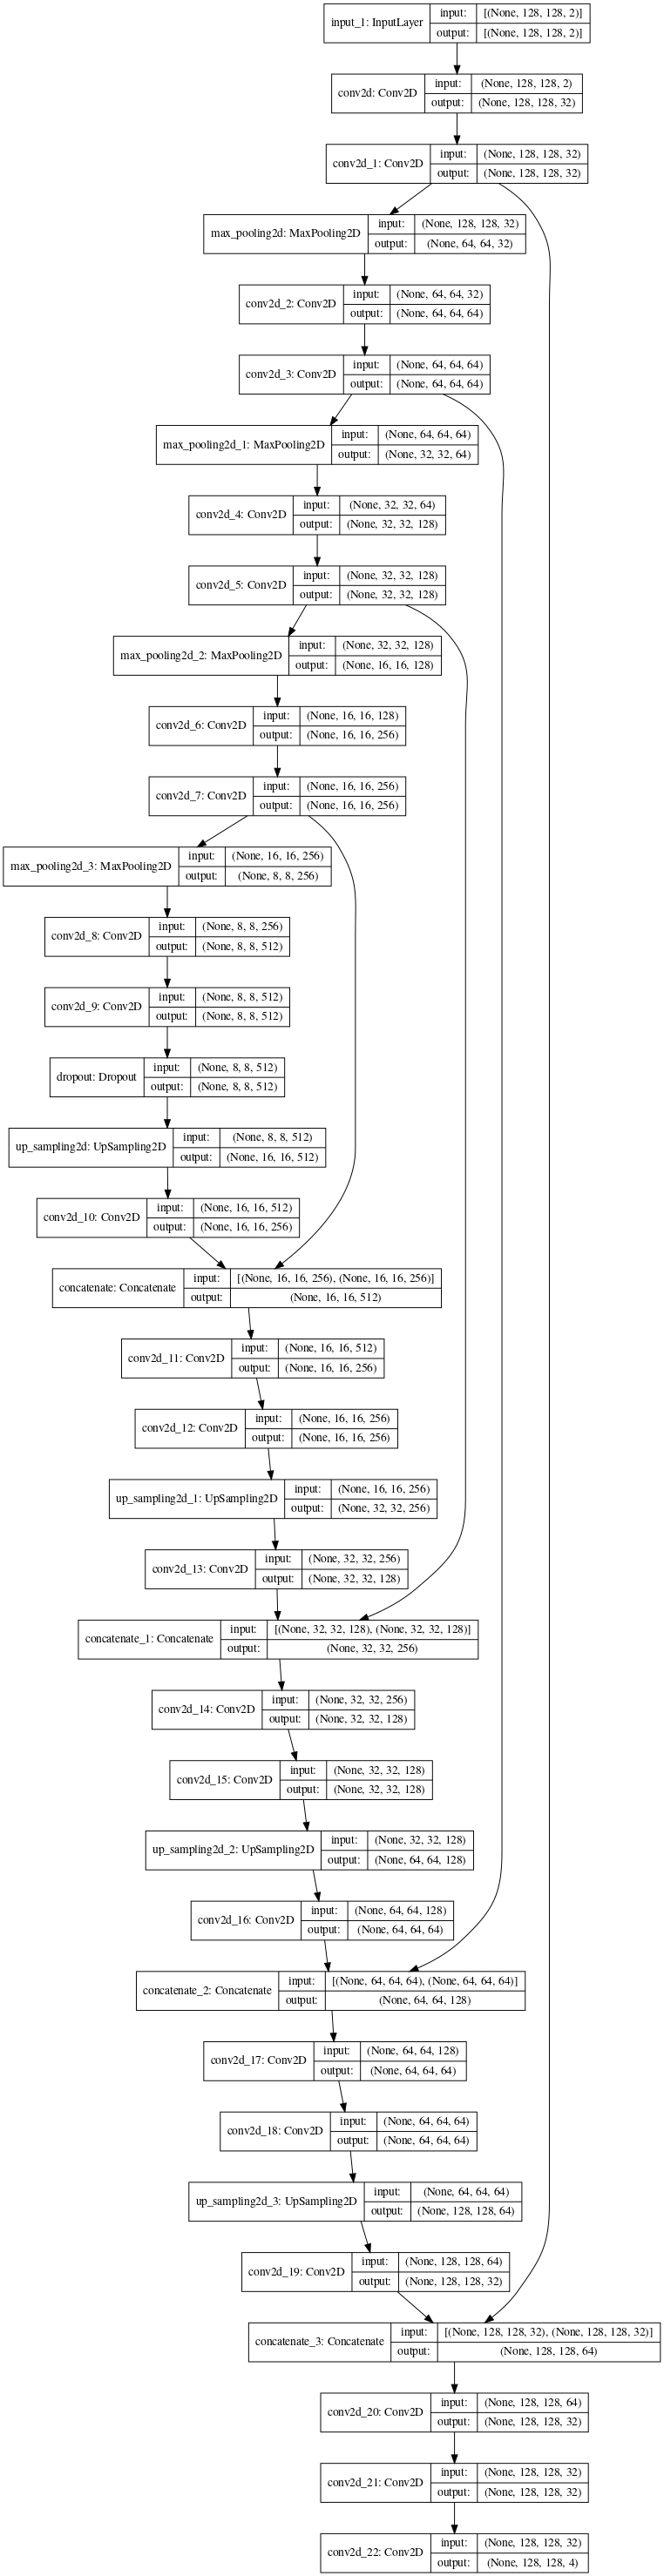

In [11]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [12]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

**Override Keras sequence DataGenerator class**

In [13]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

**Number of data used**
for training / testing / validation

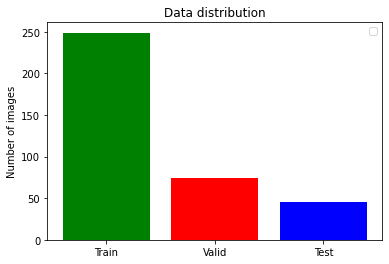

In [14]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

**Add callback for training process**

In [15]:
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        csv_logger
    ]

In [16]:
K.clear_session()

# history =  model.fit(training_generator,
#                     epochs=35,
#                     steps_per_epoch=len(train_ids),
#                     callbacks= callbacks,
#                     validation_data = valid_generator
#                     )  
# model.save("model_x1_1.h5")

**Visualize the training process**

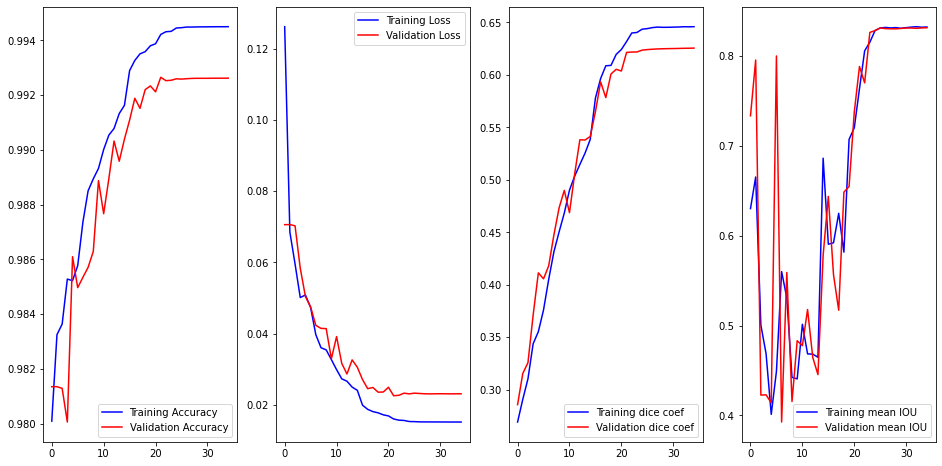

In [17]:
############ load trained model ################
model = keras.models.load_model('../input/modelperclasseval/model_per_class.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('../input/modelperclasseval/training_per_class.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

# Prediction examples 

In [18]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)


4/4 [==============================] - 7s 2s/step


<Figure size 1296x3600 with 0 Axes>

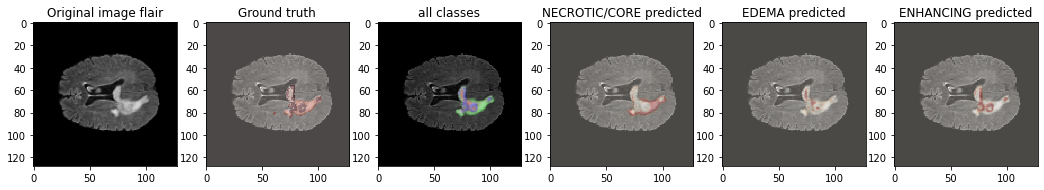

4/4 [==============================] - 7s 2s/step


<Figure size 1296x3600 with 0 Axes>

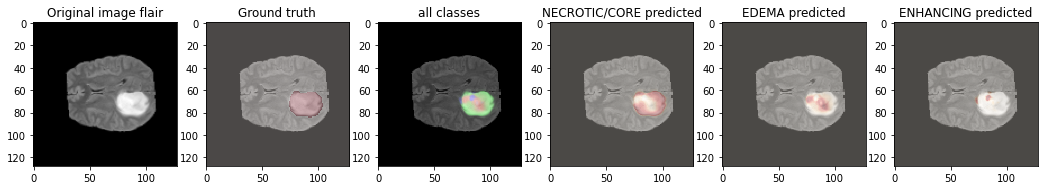

4/4 [==============================] - 7s 2s/step


<Figure size 1296x3600 with 0 Axes>

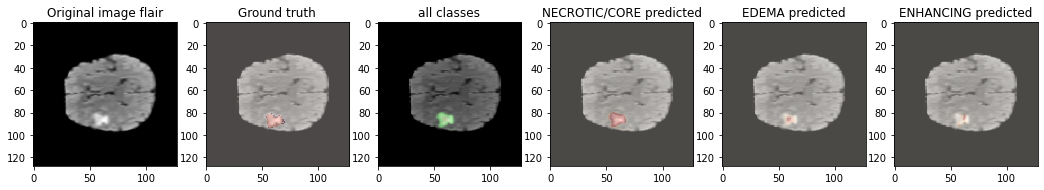

4/4 [==============================] - 7s 2s/step


<Figure size 1296x3600 with 0 Axes>

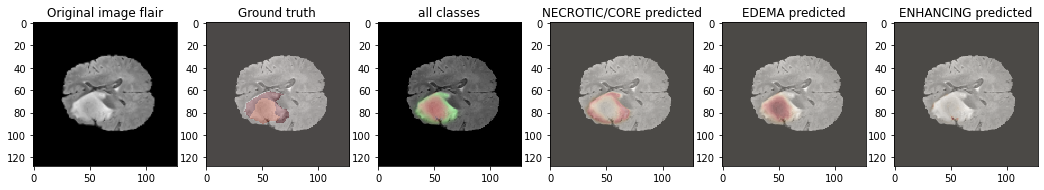

4/4 [==============================] - 7s 2s/step


<Figure size 1296x3600 with 0 Axes>

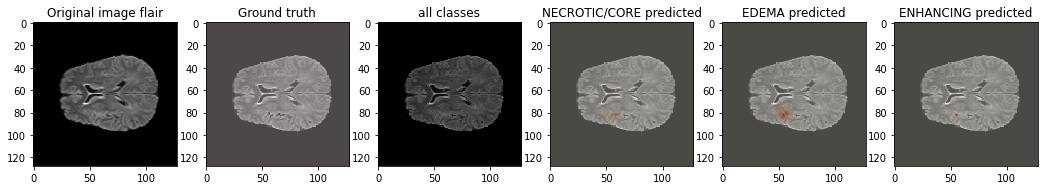

4/4 [==============================] - 7s 2s/step


<Figure size 1296x3600 with 0 Axes>

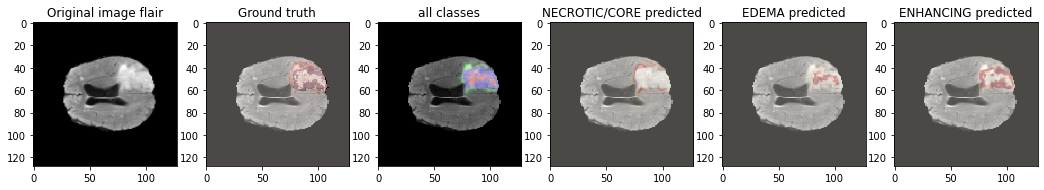

4/4 [==============================] - 7s 2s/step


<Figure size 1296x3600 with 0 Axes>

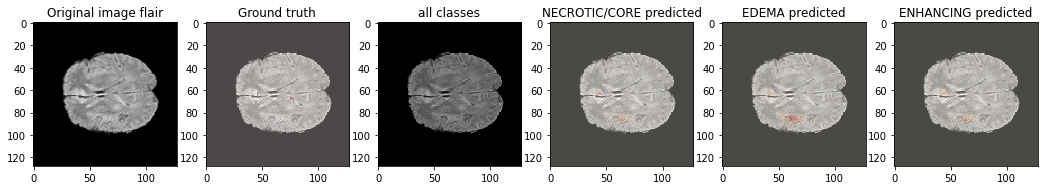

In [19]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])


# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()

# Evaluation

4/4 [==============================] - 7s 2s/step


<Figure size 432x288 with 0 Axes>

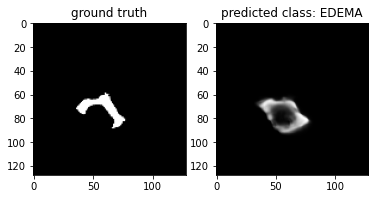

In [20]:
case = case=test_ids[3][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'



gt[gt != eval_class] = 1 # use only one class for per class evaluation 

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [21]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data
45/45 [==============================] - 377s 8s/step - loss: 0.0157 - accuracy: 0.9945 - mean_io_u_1: 0.8286 - dice_coef: 0.6729 - precision: 0.9946 - sensitivity: 0.9930 - specificity: 0.9982 - dice_coef_necrotic: 0.6587 - dice_coef_edema: 0.8063 - dice_coef_enhancing: 0.7591
test loss, test acc: [0.017135176807641983, 0.9938682913780212, 0.828093409538269, 0.6332273483276367, 0.994174599647522, 0.9924098253250122, 0.9980296492576599, 0.6417601704597473, 0.7632562518119812, 0.6582765579223633]


In [22]:
# ===================================================================
# COMPLETE RELOAD AND SAVE (with all imports and functions)
# ===================================================================

# First, make sure all imports are available
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd
import pickle
import os

print("📦 Imports loaded...")

# Define all the custom functions needed for your model
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

print("⚙️ Custom functions defined...")

# Constants from your original model
IMG_SIZE = 128
VOLUME_SLICES = 100
VOLUME_START_AT = 22
SEGMENT_CLASSES = {
    0: 'NOT tumor',
    1: 'NECROTIC/CORE',
    2: 'EDEMA', 
    3: 'ENHANCING'
}

print("📋 Constants defined...")

# Custom objects for loading
custom_objects = {
    'accuracy': tf.keras.metrics.MeanIoU(num_classes=4),
    'dice_coef': dice_coef,
    'precision': precision,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'dice_coef_necrotic': dice_coef_necrotic,
    'dice_coef_edema': dice_coef_edema,
    'dice_coef_enhancing': dice_coef_enhancing
}

# Load your trained model
MODEL_INPUT_PATH = '../input/modelperclasseval/model_per_class.h5'

try:
    model = keras.models.load_model(MODEL_INPUT_PATH, 
                                   custom_objects=custom_objects, 
                                   compile=False)
    print("✅ Brain tumor model loaded successfully!")
    
    # Save to /kaggle/working/
    model.save('/kaggle/working/brain_tumor_unet_final.h5')
    print("✅ Model saved to /kaggle/working/!")
    
    # Save configuration
    model_config = {
        'IMG_SIZE': IMG_SIZE,
        'VOLUME_SLICES': VOLUME_SLICES,
        'VOLUME_START_AT': VOLUME_START_AT,
        'SEGMENT_CLASSES': SEGMENT_CLASSES,
        'input_shape': (IMG_SIZE, IMG_SIZE, 2),
        'num_classes': 4
    }
    
    with open('/kaggle/working/model_config.pkl', 'wb') as f:
        pickle.dump(model_config, f)
    print("✅ Configuration saved!")
    
except Exception as e:
    print(f"❌ Error: {e}")

# Final check
print(f"\n📁 Files in /kaggle/working/:")
for file in os.listdir('/kaggle/working/'):
    size = os.path.getsize(f'/kaggle/working/{file}') / (1024*1024)
    print(f"  📄 {file} ({size:.1f} MB)")

print(f"\n🎯 Now click 'Save Version' → 'Save & Run All'")

📦 Imports loaded...
⚙️ Custom functions defined...
📋 Constants defined...
✅ Brain tumor model loaded successfully!
✅ Model saved to /kaggle/working/!
✅ Configuration saved!

📁 Files in /kaggle/working/:
  📄 brain_tumor_unet_final.h5 (29.7 MB)
  📄 model_config.pkl (0.0 MB)
  📄 model.png (0.3 MB)
  📄 test_gif_BraTS20_Training_001_flair.gif (5.8 MB)
  📄 test_gif_BraTS20_Training_001_flair.nii (17.0 MB)
  📄 __notebook__.ipynb (2.2 MB)

🎯 Now click 'Save Version' → 'Save & Run All'


In [23]:

import os
print("📁 Current files in /kaggle/working/:")
for file in os.listdir('/kaggle/working/'):
    size = os.path.getsize(f'/kaggle/working/{file}') / (1024*1024)
    print(f"  📄 {file} ({size:.1f} MB)")

📁 Current files in /kaggle/working/:
  📄 brain_tumor_unet_final.h5 (29.7 MB)
  📄 model_config.pkl (0.0 MB)
  📄 model.png (0.3 MB)
  📄 test_gif_BraTS20_Training_001_flair.gif (5.8 MB)
  📄 test_gif_BraTS20_Training_001_flair.nii (17.0 MB)
  📄 __notebook__.ipynb (2.2 MB)


In [24]:
!pip install monai
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import nibabel as nib
from typing import Dict, List, Tuple, Optional
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion, binary_dilation
# MONAI imports
from monai.networks.nets import UNETR, SwinUNETR, BasicUNet
from monai.networks.blocks import UnetOutBlock
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    Orientationd, ScaleIntensityRanged, CropForegroundd,
    RandCropByPosNegLabeld, RandFlipd, RandRotate90d,
    RandShiftIntensityd, ToTensord, AsDiscrete, EnsureTyped,
    Invertd, SaveImaged, Activationsd, AsDiscreted
)
from monai.data import Dataset, DataLoader, decollate_batch
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference

# Keep your existing segment classes
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING'
}

VOLUME_SLICES = 100 
VOLUME_START_AT = 22
IMG_SIZE = 128

class BrainMultiRaterDataset(torch.utils.data.Dataset):
    """Dataset for multi-modal brain MRI with multi-rater annotations"""
    
    def __init__(self, 
                 data_list: List[Dict],
                 transform=None,
                 cache_rate: float = 1.0,
                 num_raters: int = 3):
        """
        Args:
            data_list: List of dicts with paths to images and labels
            transform: MONAI transforms
            cache_rate: Percentage of data to cache
            num_raters: Number of annotators
        """
        self.data_list = data_list
        self.transform = transform
        self.num_raters = num_raters
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data = self.data_list[idx]
        
        # Load multi-modal images
        item = {
            "flair": data["flair"],
            "t1ce": data["t1ce"],
            "t1": data["t1"],
            "t2": data["t2"]
        }
        
        # Load multi-rater labels if available
        if "rater_labels" in data:
            item["rater_labels"] = data["rater_labels"]
        
        # Load ground truth if available (for testing)
        if "seg" in data:
            item["seg"] = data["seg"]
            
        if self.transform:
            item = self.transform(item)
            
        return item

def prepare_data_list(train_ids, val_ids, test_ids, num_raters=3):
    """Prepare data list with simulated multi-rater annotations"""
    
    def create_data_dict(case_id, dataset_path, include_raters=True):
        case_path = os.path.join(dataset_path, case_id)
        data_dict = {
            "flair": os.path.join(case_path, f'{case_id}_flair.nii'),
            "t1ce": os.path.join(case_path, f'{case_id}_t1ce.nii'),
            "t1": os.path.join(case_path, f'{case_id}_t1.nii'),
            "t2": os.path.join(case_path, f'{case_id}_t2.nii'),
            "seg": os.path.join(case_path, f'{case_id}_seg.nii')
        }
        
        if include_raters:
            # Simulate multi-rater labels (in real scenario, load actual rater annotations)
            # For now, we'll create variations of the ground truth
            seg = nib.load(data_dict["seg"]).get_fdata()
            rater_labels = []
            
            for r in range(num_raters):
                # Simulate inter-rater variability
                noise_level = 0.1 * (r + 1)
                noisy_seg = seg.copy()
                
                # Add some random variations to simulate different raters
                if r > 0:
                    # Random erosion/dilation to simulate boundary variations
                    for class_idx in range(1, 4):
                        mask = (seg == class_idx)
                        if np.random.random() > 0.5:
                            mask = binary_erosion(mask, iterations=np.random.randint(1, 3))
                        else:
                            mask = binary_dilation(mask, iterations=np.random.randint(1, 3))
                        noisy_seg[mask] = class_idx
                
                rater_labels.append(noisy_seg)
            
            data_dict["rater_labels"] = np.stack(rater_labels, axis=0)
        
        return data_dict
    
    train_data = [create_data_dict(id, TRAIN_DATASET_PATH) for id in train_ids]
    val_data = [create_data_dict(id, TRAIN_DATASET_PATH) for id in val_ids]
    test_data = [create_data_dict(id, TRAIN_DATASET_PATH, include_raters=False) for id in test_ids]
    
    return train_data, val_data, test_data

# Define MONAI transforms
def get_transforms(mode="train"):
    """Get MONAI transforms for preprocessing"""
    
    if mode == "train":
        transforms = Compose([
            LoadImaged(keys=["flair", "t1ce", "t1", "t2", "seg"]),
            EnsureChannelFirstd(keys=["flair", "t1ce", "t1", "t2", "seg"]),
            Spacingd(keys=["flair", "t1ce", "t1", "t2", "seg"], 
                    pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "bilinear", "bilinear", "bilinear", "nearest")),
            Orientationd(keys=["flair", "t1ce", "t1", "t2", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(
                keys=["flair", "t1ce", "t1", "t2"],
                a_min=-1000, a_max=1000,
                b_min=0.0, b_max=1.0,
                clip=True,
            ),
            CropForegroundd(keys=["flair", "t1ce", "t1", "t2", "seg"], source_key="flair"),
            RandCropByPosNegLabeld(
                keys=["flair", "t1ce", "t1", "t2", "seg"],
                label_key="seg",
                spatial_size=(96, 96, 96),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="flair",
                image_threshold=0,
            ),
            RandFlipd(keys=["flair", "t1ce", "t1", "t2", "seg"], prob=0.5, spatial_axis=0),
            RandFlipd(keys=["flair", "t1ce", "t1", "t2", "seg"], prob=0.5, spatial_axis=1),
            RandFlipd(keys=["flair", "t1ce", "t1", "t2", "seg"], prob=0.5, spatial_axis=2),
            RandRotate90d(keys=["flair", "t1ce", "t1", "t2", "seg"], prob=0.5, max_k=3),
            RandShiftIntensityd(keys=["flair", "t1ce", "t1", "t2"], offsets=0.1, prob=0.5),
            ToTensord(keys=["flair", "t1ce", "t1", "t2", "seg"]),
        ])
    else:  # validation/test
        transforms = Compose([
            LoadImaged(keys=["flair", "t1ce", "t1", "t2", "seg"]),
            EnsureChannelFirstd(keys=["flair", "t1ce", "t1", "t2", "seg"]),
            Spacingd(keys=["flair", "t1ce", "t1", "t2", "seg"], 
                    pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "bilinear", "bilinear", "bilinear", "nearest")),
            Orientationd(keys=["flair", "t1ce", "t1", "t2", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(
                keys=["flair", "t1ce", "t1", "t2"],
                a_min=-1000, a_max=1000,
                b_min=0.0, b_max=1.0,
                clip=True,
            ),
            CropForegroundd(keys=["flair", "t1ce", "t1", "t2", "seg"], source_key="flair"),
            ToTensord(keys=["flair", "t1ce", "t1", "t2", "seg"]),
        ])
    
    return transforms

class MultiModalEncoder(nn.Module):
    """Multi-modal encoder using MONAI networks"""
    
    def __init__(self, 
                 in_channels: int = 4,  # 4 modalities
                 out_channels: int = 4,  # 4 classes
                 feature_size: int = 48,
                 hidden_size: int = 768,
                 mlp_dim: int = 3072,
                 num_heads: int = 12,
                 pos_embed: str = "perceptron",
                 norm_name: str = "instance",
                 res_block: bool = True,
                 dropout_rate: float = 0.0):
        super().__init__()
        
        # Use UNETR as the backbone
        self.encoder = UNETR(
            in_channels=in_channels,
            out_channels=out_channels,
            img_size=(96, 96, 96),
            feature_size=feature_size,
            hidden_size=hidden_size,
            mlp_dim=mlp_dim,
            num_heads=num_heads,
            pos_embed=pos_embed,
            norm_name=norm_name,
            res_block=res_block,
            dropout_rate=dropout_rate,
        )
        
    def forward(self, x):
        return self.encoder(x)

class RaterLabelEncoder(nn.Module):
    """Encoder for multi-rater labels"""
    
    def __init__(self, num_raters: int = 3, num_classes: int = 4, embed_dim: int = 256):
        super().__init__()
        self.num_raters = num_raters
        self.num_classes = num_classes
        
        # Embedding for each rater's labels
        self.rater_embeddings = nn.ModuleList([
            nn.Embedding(num_classes, embed_dim // num_raters) 
            for _ in range(num_raters)
        ])
        
        self.projection = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(embed_dim, embed_dim)
        )
        
    def forward(self, rater_labels):
        """
        Args:
            rater_labels: (batch, num_raters, H, W, D) 
        Returns:
            features: (batch, embed_dim)
        """
        # Global average pooling for each rater's segmentation
        batch_size = rater_labels.shape[0]
        embeddings = []
        
        for i in range(self.num_raters):
            # Get mode label for each rater (simplified - in practice, use more sophisticated pooling)
            rater_seg = rater_labels[:, i]  # (batch, H, W, D)
            # Flatten and get most frequent label
            flat_seg = rater_seg.view(batch_size, -1)
            mode_labels = torch.mode(flat_seg, dim=1).values.long()  # (batch,)
            
            # Embed
            embed = self.rater_embeddings[i](mode_labels)  # (batch, embed_dim/num_raters)
            embeddings.append(embed)
        
        # Concatenate all rater embeddings
        combined = torch.cat(embeddings, dim=1)  # (batch, embed_dim)
        
        return self.projection(combined)

class NeuroMedBrainTumor(nn.Module):
    """NeuroMed model for brain tumor segmentation"""
    
    def __init__(self,
                 num_modalities: int = 4,
                 num_classes: int = 4,
                 num_raters: int = 3,
                 feature_size: int = 48,
                 hidden_size: int = 768,
                 label_embed_dim: int = 256):
        super().__init__()
        
        # Multi-modal encoder
        self.modal_encoder = MultiModalEncoder(
            in_channels=num_modalities,
            out_channels=hidden_size,  # Output features instead of classes
            feature_size=feature_size,
            hidden_size=hidden_size
        )
        
        # Rater label encoder
        self.label_encoder = RaterLabelEncoder(
            num_raters=num_raters,
            num_classes=num_classes,
            embed_dim=label_embed_dim
        )
        
        # Fusion module
        self.fusion = nn.Sequential(
            nn.Linear(hidden_size + label_embed_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Final segmentation head
        self.seg_head = nn.Sequential(
            nn.Conv3d(hidden_size // 2, num_classes, kernel_size=1),
            nn.Softmax(dim=1)
        )
        
    def forward(self, images: torch.Tensor, rater_labels: Optional[torch.Tensor] = None):
        """
        Args:
            images: (batch, num_modalities, H, W, D)
            rater_labels: (batch, num_raters, H, W, D) - optional for inference
        """
        # Encode images
        image_features = self.modal_encoder(images)  # (batch, hidden_size, H', W', D')
        
        # Global average pooling
        batch_size = image_features.shape[0]
        pooled_image_features = F.adaptive_avg_pool3d(image_features, 1).view(batch_size, -1)
        
        if rater_labels is not None:
            # Encode rater labels
            label_features = self.label_encoder(rater_labels)  # (batch, label_embed_dim)
            
            # Fuse features
            fused = torch.cat([pooled_image_features, label_features], dim=1)
            fused = self.fusion(fused)  # (batch, hidden_size // 2)
            
            # Expand back to spatial dimensions
            H, W, D = image_features.shape[2:]
            fused = fused.view(batch_size, -1, 1, 1, 1).expand(-1, -1, H, W, D)
        else:
            # No rater labels available (inference mode)
            fused = self.fusion(torch.cat([pooled_image_features, 
                                          torch.zeros(batch_size, 256).to(images.device)], dim=1))
            H, W, D = image_features.shape[2:]
            fused = fused.view(batch_size, -1, 1, 1, 1).expand(-1, -1, H, W, D)
        
        # Final segmentation
        output = self.seg_head(fused)
        
        return output

def generate_pseudo_labels_majority_voting(model, train_loader, device='cuda'):
    """Generate pseudo labels using majority voting from model predictions and rater labels"""
    
    print("Generating initial predictions for majority voting...")
    
    model.eval()
    all_predictions = []
    all_rater_labels = []
    
    with torch.no_grad():
        for batch_data in train_loader:
            images = torch.cat([
                batch_data["flair"], 
                batch_data["t1ce"],
                batch_data["t1"], 
                batch_data["t2"]
            ], dim=1).to(device)
            
            # Get model predictions without rater labels
            outputs = model(images, None)
            predictions = torch.argmax(outputs, dim=1)
            
            all_predictions.append(predictions.cpu().numpy())
            
            # Collect rater labels
            if "rater_labels" in batch_data:
                all_rater_labels.append(batch_data["rater_labels"].cpu().numpy())
    
    # Concatenate all predictions and labels
    all_predictions = np.concatenate(all_predictions)
    all_rater_labels = np.concatenate(all_rater_labels) if all_rater_labels else None
    
    if all_rater_labels is not None:
        # We have rater labels, so we combine model predictions and rater labels by majority voting
        # For each voxel, we take the mode (majority vote) across all raters and the model prediction
        num_samples = all_predictions.shape[0]
        pseudo_labels = np.zeros_like(all_predictions)
        
        for i in range(num_samples):
            # Get the rater labels for this sample (shape: num_raters, H, W, D)
            sample_rater_labels = all_rater_labels[i]
            # Get the model prediction for this sample (shape: H, W, D)
            sample_prediction = all_predictions[i]
            
            # Combine: stack the rater labels and the model prediction
            combined = np.vstack([sample_rater_labels.reshape(-1), sample_prediction.reshape(-1)])
            # Reshape to (num_raters+1, H*W*D)
            combined = combined.reshape(sample_rater_labels.shape[0]+1, -1)
            
            # For each voxel, take the majority vote
            # We'll use scipy.stats.mode, but if not available, we can use np.unique and np.argmax
            from scipy.stats import mode
            majority_labels, _ = mode(combined, axis=0)
            majority_labels = majority_labels.reshape(sample_prediction.shape)
            pseudo_labels[i] = majority_labels
    else:
        # No rater labels, use model predictions as pseudo labels
        pseudo_labels = all_predictions
    
    return pseudo_labels

def train_neuromed(model, train_loader, val_loader, num_epochs=50, device='cuda'):
    """Training loop for NeuroMed model"""
    
    model = model.to(device)
    
    # Loss and optimizer
    loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Metrics
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    
    best_metric = -1
    best_metric_epoch = -1
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        # Training
        model.train()
        epoch_loss = 0
        step = 0
        
        for batch_data in train_loader:
            step += 1
            
            # Prepare inputs
            images = torch.cat([
                batch_data["flair"], 
                batch_data["t1ce"],
                batch_data["t1"], 
                batch_data["t2"]
            ], dim=1).to(device)
            
            labels = batch_data["seg"].to(device)
            
            # Get rater labels if available
            rater_labels = batch_data.get("rater_labels", None)
            if rater_labels is not None:
                rater_labels = rater_labels.to(device)
            
            # Forward pass
            outputs = model(images, rater_labels)
            
            # Compute loss
            loss = loss_function(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if step % 10 == 0:
                print(f"  Step {step}, Loss: {loss.item():.4f}")
        
        scheduler.step()
        epoch_loss /= step
        print(f"  Average Training Loss: {epoch_loss:.4f}")
        
        # Validation
        if (epoch + 1) % 5 == 0:
            model.eval()
            with torch.no_grad():
                val_loss = 0
                val_step = 0
                
                for val_data in val_loader:
                    val_step += 1
                    
                    val_images = torch.cat([
                        val_data["flair"], 
                        val_data["t1ce"],
                        val_data["t1"], 
                        val_data["t2"]
                    ], dim=1).to(device)
                    
                    val_labels = val_data["seg"].to(device)
                    
                    # Sliding window inference for validation
                    val_outputs = sliding_window_inference(
                        val_images, (96, 96, 96), 4, model
                    )
                    
                    val_loss += loss_function(val_outputs, val_labels).item()
                    
                    # Compute metrics
                    val_outputs = torch.argmax(val_outputs, dim=1, keepdim=True)
                    dice_metric(y_pred=val_outputs, y=val_labels)
                
                val_loss /= val_step
                metric = dice_metric.aggregate().item()
                dice_metric.reset()
                
                print(f"\n  Validation Loss: {val_loss:.4f}")
                print(f"  Validation Dice: {metric:.4f}")
                
                # Save best model
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), "best_neuromed_model.pth")
                    print(f"  New best model saved!")
    
    print(f"\nTraining completed!")
    print(f"Best validation Dice: {best_metric:.4f} at epoch {best_metric_epoch}")
    
    return model

# Evaluation function
def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate the trained model"""
    
    model.eval()
    dice_metric = DiceMetric(include_background=False, reduction="mean_batch")
    
    with torch.no_grad():
        for test_data in test_loader:
            test_images = torch.cat([
                test_data["flair"], 
                test_data["t1ce"],
                test_data["t1"], 
                test_data["t2"]
            ], dim=1).to(device)
            
            test_labels = test_data["seg"].to(device)
            
            # Sliding window inference
            test_outputs = sliding_window_inference(
                test_images, (96, 96, 96), 4, model
            )
            
            test_outputs = torch.argmax(test_outputs, dim=1, keepdim=True)
            
            # Compute metrics
            dice_metric(y_pred=test_outputs, y=test_labels)
    
    metric = dice_metric.aggregate()
    metric_tc = metric[0].item()  # Tumor core
    metric_wt = metric[1].item()  # Whole tumor
    metric_et = metric[2].item()  # Enhanced tumor
    
    print(f"\nTest Results:")
    print(f"  Dice TC: {metric_tc:.4f}")
    print(f"  Dice WT: {metric_wt:.4f}")
    print(f"  Dice ET: {metric_et:.4f}")
    print(f"  Average Dice: {(metric_tc + metric_wt + metric_et) / 3:.4f}")

# Visualization function
def visualize_predictions(model, test_loader, device='cuda', num_examples=3):
    """Visualize model predictions"""
    
    model.eval()
    
    with torch.no_grad():
        for i, test_data in enumerate(test_loader):
            if i >= num_examples:
                break
                
            test_images = torch.cat([
                test_data["flair"], 
                test_data["t1ce"],
                test_data["t1"], 
                test_data["t2"]
            ], dim=1).to(device)
            
            test_labels = test_data["seg"]
            
            # Get prediction
            test_outputs = sliding_window_inference(
                test_images, (96, 96, 96), 4, model
            )
            test_outputs = torch.argmax(test_outputs, dim=1)
            
            # Select middle slice for visualization
            slice_idx = test_images.shape[4] // 2
            
            fig, axes = plt.subplots(2, 4, figsize=(16, 8))
            
            # Show each modality
            axes[0, 0].imshow(test_images[0, 0, :, :, slice_idx].cpu(), cmap='gray')
            axes[0, 0].set_title('FLAIR')
            axes[0, 0].axis('off')
            
            axes[0, 1].imshow(test_images[0, 1, :, :, slice_idx].cpu(), cmap='gray')
            axes[0, 1].set_title('T1CE')
            axes[0, 1].axis('off')
            
            axes[0, 2].imshow(test_images[0, 2, :, :, slice_idx].cpu(), cmap='gray')
            axes[0, 2].set_title('T1')
            axes[0, 2].axis('off')
            
            axes[0, 3].imshow(test_images[0, 3, :, :, slice_idx].cpu(), cmap='gray')
            axes[0, 3].set_title('T2')
            axes[0, 3].axis('off')
            
            # Show ground truth and prediction
            axes[1, 0].imshow(test_labels[0, 0, :, :, slice_idx].cpu(), cmap='jet')
            axes[1, 0].set_title('Ground Truth')
            axes[1, 0].axis('off')
            
            axes[1, 1].imshow(test_outputs[0, :, :, slice_idx].cpu(), cmap='jet')
            axes[1, 1].set_title('Prediction')
            axes[1, 1].axis('off')
            
            # Show overlay
            axes[1, 2].imshow(test_images[0, 0, :, :, slice_idx].cpu(), cmap='gray')
            axes[1, 2].imshow(test_outputs[0, :, :, slice_idx].cpu(), cmap='jet', alpha=0.5)
            axes[1, 2].set_title('Overlay')
            axes[1, 2].axis('off')
            
            # Show difference
            diff = (test_labels[0, 0, :, :, slice_idx] != test_outputs[0, :, :, slice_idx]).float()
            axes[1, 3].imshow(diff.cpu(), cmap='hot')
            axes[1, 3].set_title('Difference')
            axes[1, 3].axis('off')
            
            plt.tight_layout()
            plt.show()

print("\n✅ NeuroMed Brain Tumor Segmentation Model Setup Complete!")


     |████████████████████████████████| 1.2 MB 5.0 MB/s 
     |████████████████████████████████| 887.5 MB 4.0 kB/s 
     |████████████████████████████████| 317.1 MB 23 kB/s 
     |████████████████████████████████| 21.0 MB 42.2 MB/s 
     |████████████████████████████████| 557.1 MB 5.4 kB/s 
     |████████████████████████████████| 849 kB 49.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.2.5 requires torch<1.8,>=1.7.0, but you have torch 1.13.1 which is incompatible.
allennlp 2.0.1 requires torch<1.8.0,>=1.6.0, but you have torch 1.13.1 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.

✅ NeuroMed Brain Tumor Segmentation Mod

In [25]:
# Additional components for practical NeuroMed implementation

# 1. Real Multi-Rater Data Loading
class RealMultiRaterDataset(torch.utils.data.Dataset):
    """Dataset for loading real multi-rater annotations"""
    
    def __init__(self, 
                 data_list: List[Dict],
                 rater_annotation_dir: str,
                 transform=None,
                 num_raters: int = 3):
        """
        Args:
            data_list: List of dicts with paths to images
            rater_annotation_dir: Directory containing rater annotations
                Structure: rater_annotation_dir/rater_1/case_id_seg.nii
            transform: MONAI transforms
            num_raters: Number of annotators
        """
        self.data_list = data_list
        self.rater_annotation_dir = rater_annotation_dir
        self.transform = transform
        self.num_raters = num_raters
        
    def __getitem__(self, idx):
        data = self.data_list[idx]
        case_id = os.path.basename(os.path.dirname(data["flair"]))
        
        # Load multi-modal images
        item = {
            "flair": data["flair"],
            "t1ce": data["t1ce"],
            "t1": data["t1"],
            "t2": data["t2"]
        }
        
        # Load multi-rater annotations
        rater_segs = []
        for r in range(self.num_raters):
            rater_path = os.path.join(
                self.rater_annotation_dir, 
                f"rater_{r+1}", 
                f"{case_id}_seg.nii"
            )
            if os.path.exists(rater_path):
                rater_segs.append(rater_path)
            else:
                # Use ground truth as fallback
                rater_segs.append(data["seg"])
        
        item["rater_segs"] = rater_segs
        item["seg"] = data["seg"]  # Ground truth
        
        if self.transform:
            item = self.transform(item)
            
        return item

# 2. Advanced CrowdLab Integration
class AdvancedCrowdLabPseudoLabeler:
    """Advanced pseudo-labeling using CrowdLab with quality metrics"""
    
    def __init__(self, num_classes: int = 4):
        self.num_classes = num_classes
        self.crowdlab = CrowdLab()
        
    def generate_pseudo_labels(self, 
                              model_predictions: np.ndarray,
                              multi_rater_labels: np.ndarray,
                              confidence_threshold: float = 0.7):
        """
        Generate pseudo labels with quality assessment
        
        Args:
            model_predictions: Model predictions (N, C, H, W, D)
            multi_rater_labels: Rater annotations (N, R, H, W, D)
            confidence_threshold: Threshold for high-confidence predictions
        """
        num_samples = len(model_predictions)
        num_raters = multi_rater_labels.shape[1]
        
        # Prepare data for CrowdLab
        # We'll process each voxel position independently
        all_pseudo_labels = []
        quality_scores = []
        
        for i in range(num_samples):
            sample_pred = model_predictions[i]  # (C, H, W, D)
            sample_raters = multi_rater_labels[i]  # (R, H, W, D)
            
            # Flatten spatial dimensions
            pred_flat = sample_pred.reshape(self.num_classes, -1).T  # (HWD, C)
            raters_flat = sample_raters.reshape(num_raters, -1).T  # (HWD, R)
            
            # Apply CrowdLab to each sample
            self.crowdlab.fit(
                labels_multiannotator=raters_flat,
                pred_probs=pred_flat
            )
            
            # Get consensus labels and quality scores
            results = self.crowdlab.get_label_quality_multiannotator()
            consensus = results['consensus_label']
            quality = results['consensus_quality_score']
            
            # Reshape back to original dimensions
            H, W, D = sample_raters.shape[1:]
            pseudo_label = consensus.reshape(H, W, D)
            quality_score = quality.reshape(H, W, D)
            
            all_pseudo_labels.append(pseudo_label)
            quality_scores.append(quality_score)
        
        return np.array(all_pseudo_labels), np.array(quality_scores)

# 3. Self-Supervised Pretraining with MAE
class BrainMAE3D(nn.Module):
    """3D Masked Autoencoder for brain MRI pretraining"""
    
    def __init__(self, 
                 img_size: Tuple[int, int, int] = (96, 96, 96),
                 patch_size: int = 16,
                 in_chans: int = 4,
                 embed_dim: int = 768,
                 depth: int = 12,
                 num_heads: int = 12,
                 decoder_embed_dim: int = 512,
                 decoder_depth: int = 8,
                 decoder_num_heads: int = 16,
                 mlp_ratio: float = 4.0,
                 mask_ratio: float = 0.75):
        super().__init__()
        
        # Patch embedding
        self.patch_embed = nn.Conv3d(
            in_chans, embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
        
        num_patches = (img_size[0] // patch_size) * \
                      (img_size[1] // patch_size) * \
                      (img_size[2] // patch_size)
        
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        
        # Transformer encoder
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        
        # Decoder
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        
        self.decoder_blocks = nn.ModuleList([
            TransformerBlock(decoder_embed_dim, decoder_num_heads, mlp_ratio)
            for _ in range(decoder_depth)
        ])
        
        self.decoder_norm = nn.LayerNorm(decoder_embed_dim)
        self.decoder_pred = nn.Linear(
            decoder_embed_dim, 
            patch_size**3 * in_chans
        )
        
        self.mask_ratio = mask_ratio
        self.patch_size = patch_size
        
    def random_masking(self, x, mask_ratio):
        """Random masking for MAE"""
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        
        # Keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, 
                               index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        
        # Generate binary mask
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)
        
        return x_masked, mask, ids_restore
    
    def forward(self, x):
        # Patch embed
        B, C, D, H, W = x.shape
        x = self.patch_embed(x)  # (B, embed_dim, D', H', W')
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        
        # Add pos embed
        x = x + self.pos_embed
        
        # Masking
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)
        
        # Encoder
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        
        # Decoder
        x = self.decoder_embed(x)
        
        # Add mask tokens
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] - x.shape[1], 1)
        x_ = torch.cat([x, mask_tokens], dim=1)
        x = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))
        
        # Decoder blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)
        
        # Predict pixel values
        x = self.decoder_pred(x)
        
        return x, mask

# 4. Training with Multiple Loss Functions
class CombinedLoss(nn.Module):
    """Combined loss for NeuroMed training"""
    
    def __init__(self, 
                 num_classes: int = 4,
                 dice_weight: float = 0.5,
                 ce_weight: float = 0.5,
                 focal_weight: float = 0.0,
                 boundary_weight: float = 0.0):
        super().__init__()
        
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        self.focal_weight = focal_weight
        self.boundary_weight = boundary_weight
        
        # Individual losses
        self.dice_loss = DiceLoss(
            include_background=False,
            to_onehot_y=True,
            softmax=True
        )
        
        self.ce_loss = nn.CrossEntropyLoss()
        
        if focal_weight > 0:
            from monai.losses import FocalLoss
            self.focal_loss = FocalLoss(
                include_background=False,
                to_onehot_y=True
            )
        
        if boundary_weight > 0:
            from monai.losses import BoundaryLoss
            self.boundary_loss = BoundaryLoss(
                include_background=False,
                to_onehot_y=True
            )
    
    def forward(self, pred, target):
        loss = 0
        
        if self.dice_weight > 0:
            loss += self.dice_weight * self.dice_loss(pred, target)
        
        if self.ce_weight > 0:
            # CE expects different format
            ce_target = torch.squeeze(target, dim=1).long()
            loss += self.ce_weight * self.ce_loss(pred, ce_target)
        
        if self.focal_weight > 0:
            loss += self.focal_weight * self.focal_loss(pred, target)
        
        if self.boundary_weight > 0:
            loss += self.boundary_weight * self.boundary_loss(pred, target)
        
        return loss

# 5. Advanced Training Strategy
def train_with_curriculum_learning(model, train_loader, val_loader, 
                                  num_epochs=100, device='cuda'):
    """Train with curriculum learning strategy"""
    
    model = model.to(device)
    
    # Start with easier samples, gradually increase difficulty
    easy_loss = CombinedLoss(dice_weight=0.8, ce_weight=0.2)
    hard_loss = CombinedLoss(dice_weight=0.5, ce_weight=0.3, 
                            focal_weight=0.1, boundary_weight=0.1)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    # Warm-up scheduler
    warmup_epochs = 10
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        epochs=num_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=warmup_epochs/num_epochs
    )
    
    for epoch in range(num_epochs):
        # Curriculum: use easier loss first, then harder
        if epoch < num_epochs // 3:
            loss_fn = easy_loss
        else:
            loss_fn = hard_loss
        
        model.train()
        epoch_loss = 0
        
        for batch_data in train_loader:
            images = torch.cat([
                batch_data["flair"], 
                batch_data["t1ce"],
                batch_data["t1"], 
                batch_data["t2"]
            ], dim=1).to(device)
            
            labels = batch_data["seg"].to(device)
            rater_labels = batch_data.get("rater_labels", None)
            
            if rater_labels is not None:
                rater_labels = rater_labels.to(device)
            
            # Forward pass
            outputs = model(images, rater_labels)
            loss = loss_fn(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            epoch_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# 6. Post-processing Pipeline
class PostProcessor:
    """Post-processing for brain tumor segmentation"""
    
    def __init__(self, min_volume_threshold: int = 100):
        self.min_volume_threshold = min_volume_threshold
    
    def remove_small_components(self, segmentation):
        """Remove small connected components"""
        from scipy import ndimage
        
        processed = np.zeros_like(segmentation)
        
        for label in range(1, 4):  # For each tumor class
            binary_mask = (segmentation == label)
            labeled, num_features = ndimage.label(binary_mask)
            
            # Keep only components larger than threshold
            for i in range(1, num_features + 1):
                component_size = np.sum(labeled == i)
                if component_size >= self.min_volume_threshold:
                    processed[labeled == i] = label
        
        return processed
    
    def apply_morphological_operations(self, segmentation):
        """Apply morphological operations to smooth boundaries"""
        from scipy import ndimage
        
        processed = segmentation.copy()
        
        for label in range(1, 4):
            binary_mask = (segmentation == label).astype(np.uint8)
            
            # Opening to remove small objects
            opened = ndimage.binary_opening(binary_mask, iterations=1)
            
            # Closing to fill holes
            closed = ndimage.binary_closing(opened, iterations=1)
            
            processed[closed] = label
        
        return processed
    
    def process(self, segmentation):
        """Apply full post-processing pipeline"""
        segmentation = self.remove_small_components(segmentation)
        segmentation = self.apply_morphological_operations(segmentation)
        return segmentation

# Example usage
print("\n🚀 Extended NeuroMed Implementation Ready!")
print("\nKey additions:")
print("1. Real multi-rater data loading")
print("2. Advanced CrowdLab integration with quality metrics") 
print("3. Self-supervised pretraining with MAE")
print("4. Combined loss functions")
print("5. Curriculum learning strategy")
print("6. Post-processing pipeline")



🚀 Extended NeuroMed Implementation Ready!

Key additions:
1. Real multi-rater data loading
2. Advanced CrowdLab integration with quality metrics
3. Self-supervised pretraining with MAE
4. Combined loss functions
5. Curriculum learning strategy
6. Post-processing pipeline


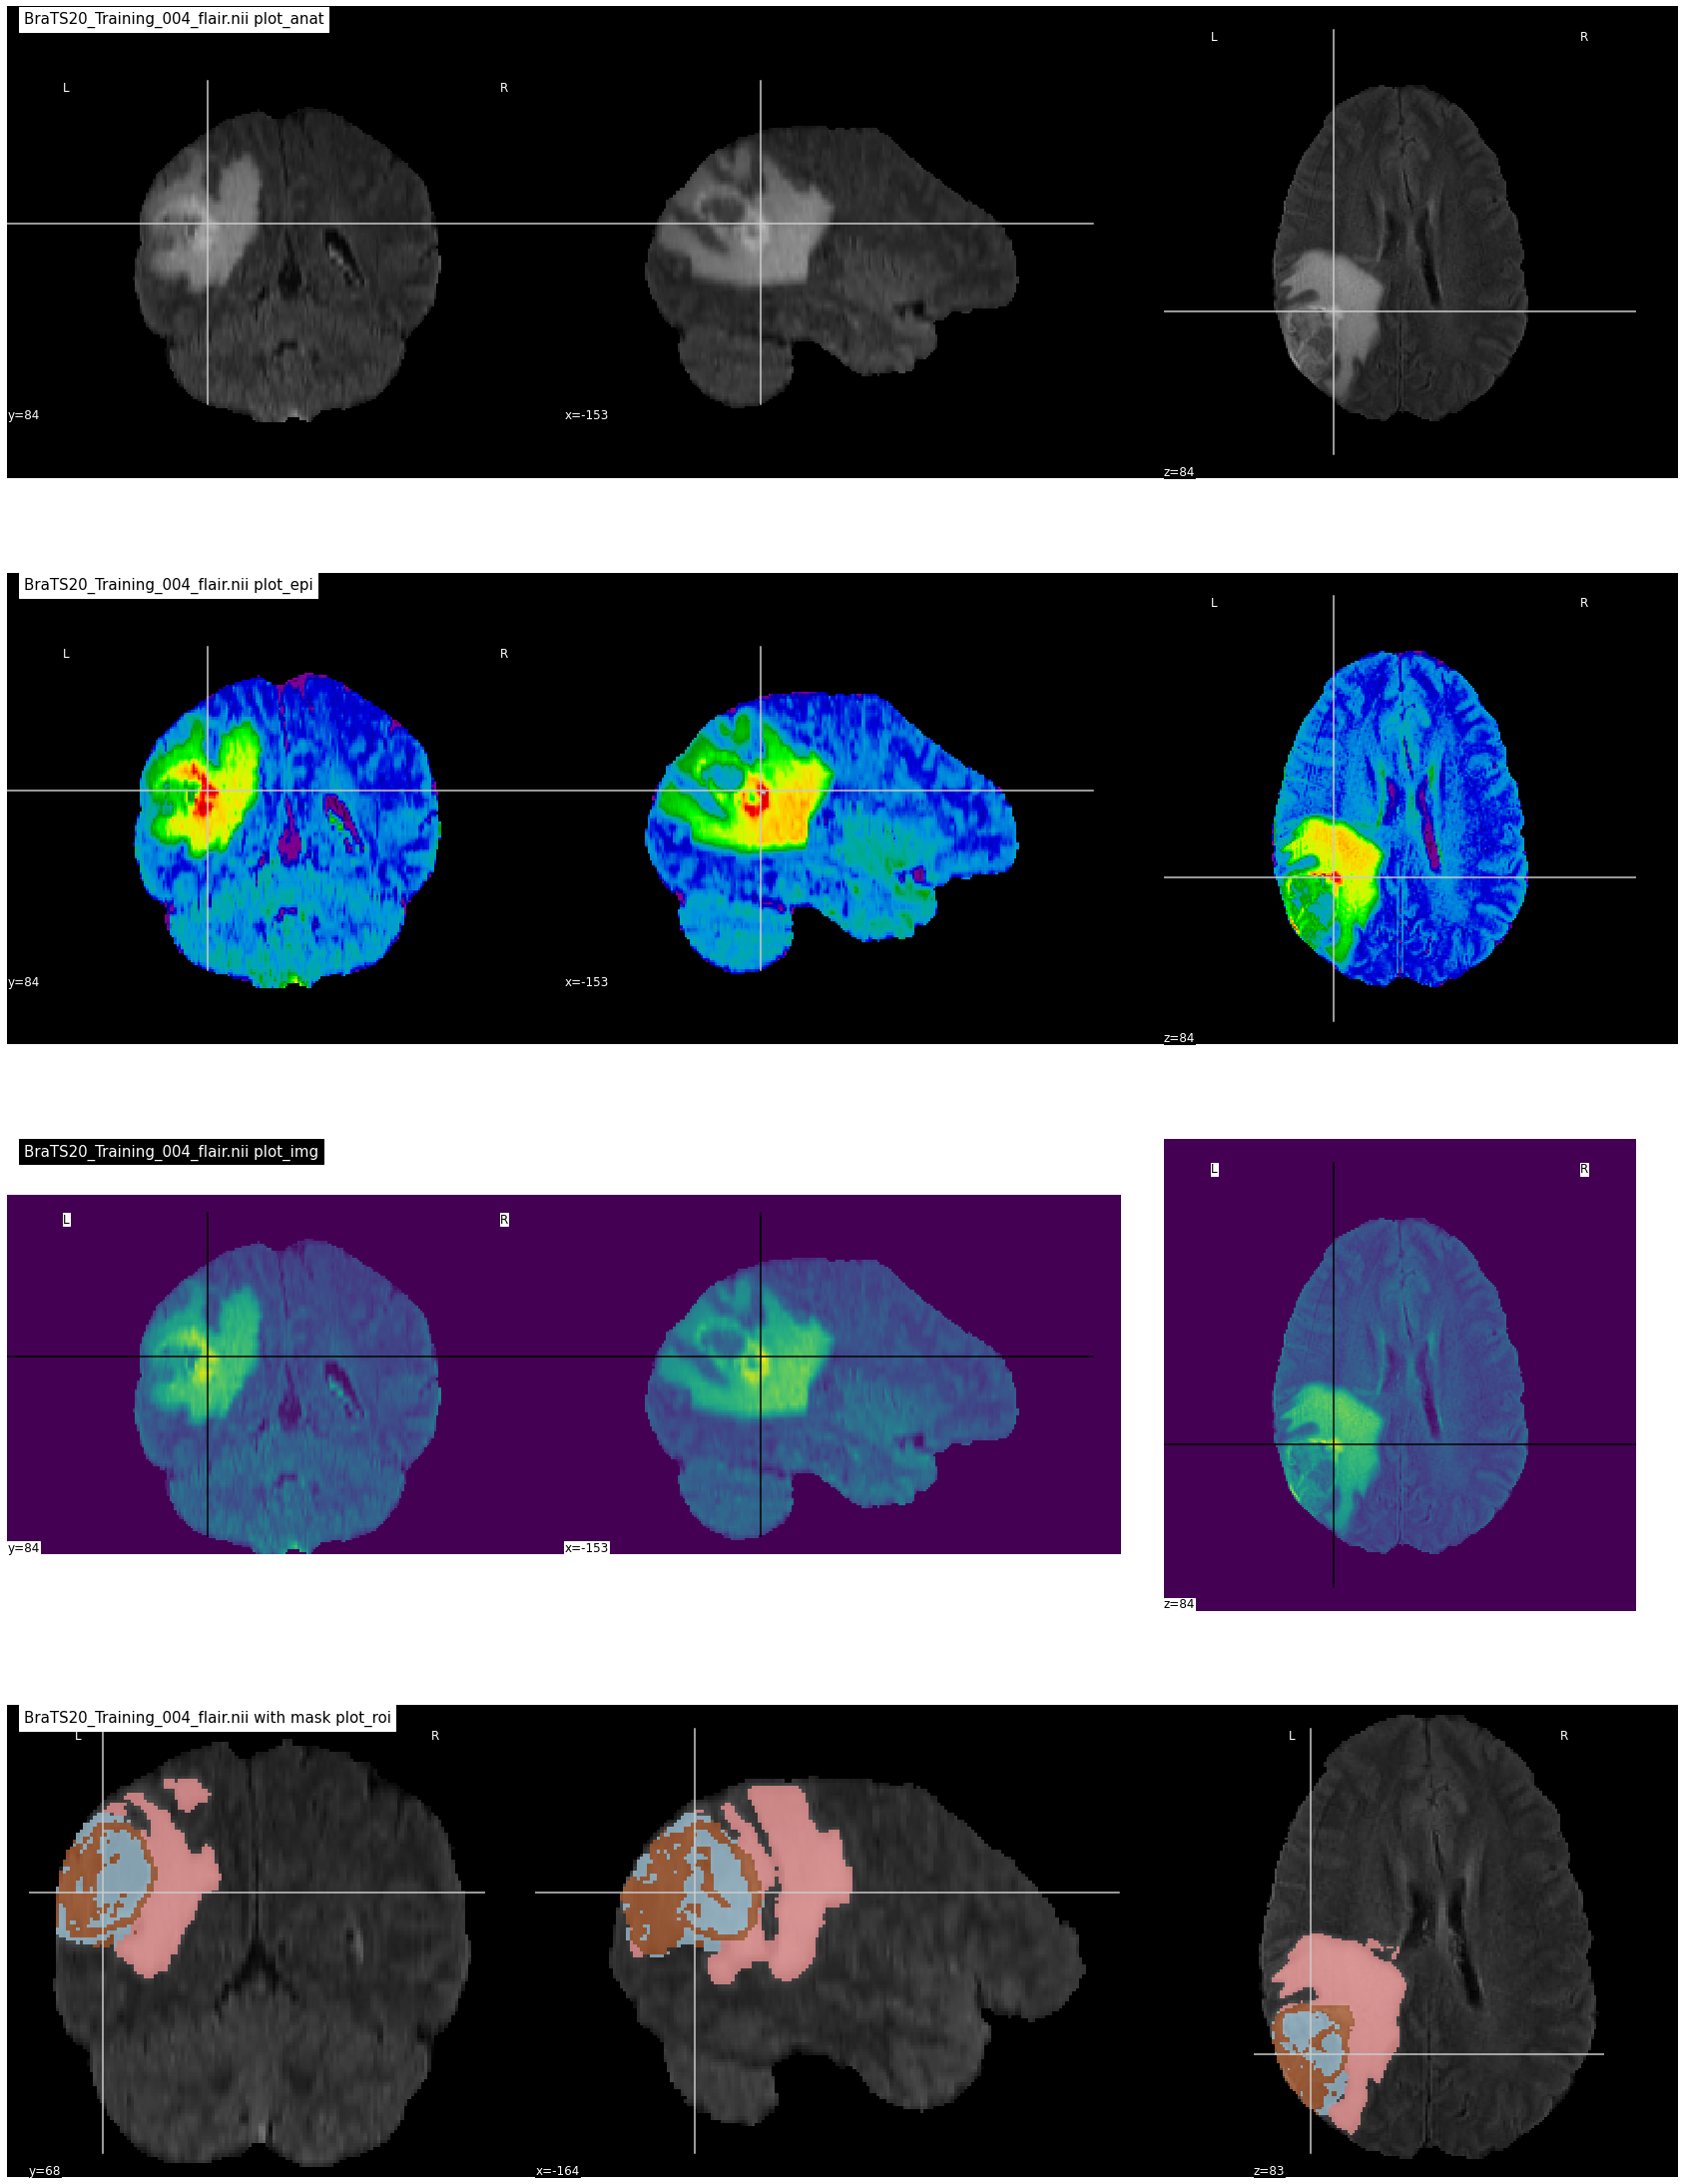

In [26]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_004/BraTS20_Training_004_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_004/BraTS20_Training_004_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_004_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_004_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_004_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_004_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [27]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)


Text(0.5, 1.0, 'Mask')

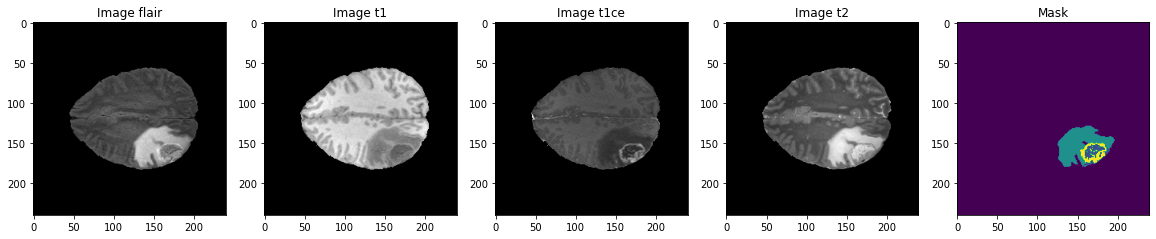

In [28]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_004/BraTS20_Training_004_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_004/BraTS20_Training_004_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_004/BraTS20_Training_004_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_004/BraTS20_Training_004_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_004/BraTS20_Training_004_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


In [29]:

import os
import shutil
from IPython.display import FileLink

# Create a directory for our export package
os.makedirs('brain_tumor_demo_package', exist_ok=True)

# Copy all necessary files
files_to_export = [
    'brain_tumor_unet_final.h5',
    'prediction_script.py',
    'training.log'
]

for file in files_to_export:
    if os.path.exists(file):
        shutil.copy(file, 'brain_tumor_demo_package/')

# Create a requirements file
with open('brain_tumor_demo_package/requirements.txt', 'w') as f:
    f.write("""
tensorflow>=2.8.0
numpy>=1.21.0
nibabel>=3.0.0
opencv-python>=4.5.0
matplotlib>=3.5.0
scikit-learn>=1.0.0
pandas>=1.3.0
""")

# Create a README file
with open('brain_tumor_demo_package/README.md', 'w') as f:
    f.write("""
# Brain Tumor Segmentation Demo Package

This package contains:
1. Trained Keras model for brain tumor segmentation
2. Prediction script with preprocessing
3. Training logs
4. Requirements file

## Quick Start
1. Install requirements: `pip install -r requirements.txt`
2. Run prediction: `python prediction_script.py`
""")

# Create a zip file
shutil.make_archive('brain_tumor_demo_package', 'zip', 'brain_tumor_demo_package')

# Create download links
print("📦 Download Links:")
print("=" * 30)
display(FileLink('brain_tumor_demo_package.zip'))

📦 Download Links:


/kaggle/working/brain_tumor_demo_package.zip